In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata #need to use pip install sodapy to get this, using it to get data from the CDC website
import os

data_prefix = 'Data/'
output_prefix_01 = '01_data_processing.ipynb.output/'

## Getting Data

In [39]:
#make a Data folder if one doesn't exist
if not os.path.exists(data_prefix):
    os.makedirs(data_prefix)

#check if the data files exist, otherwise pull from the CDC website
if not os.path.exists(data_prefix + 'covid_rates.csv'):
    print('Downloading data from CDC website')
    ## pulling data from CDC website using Socrata API
    # Create a client object
    client = Socrata("data.cdc.gov", None)

    # pull rsv, covid, and flu rates data https://data.cdc.gov/Public-Health-Surveillance/Rates-of-Laboratory-Confirmed-RSV-COVID-19-and-Flu/kvib-3txy/about_data
    covid_rates_results = client.get("kvib-3txy",limit=47333)
    # Convert to pandas DataFrame
    covid_rates_df = pd.DataFrame.from_records(covid_rates_results)
    #pull youth obesity data https://data.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Youth-Risk/vba9-s8jp/about_data
    youth_results = client.get("vba9-s8jp", limit=50092)
    # Convert to pandas DataFrame
    youth_df = pd.DataFrame.from_records(youth_results)
    #pull adult obesity data https://chronicdata.cdc.gov/Nutrition-Physical-Activity-and-Obesity/Nutrition-Physical-Activity-and-Obesity-Behavioral/hn4x-zwk7/about_data
    adult_results = client.get("hn4x-zwk7", limit=104272)
    # Convert to pandas DataFrame
    adult_df = pd.DataFrame.from_records(adult_results)

    #download the data into the data folder
    covid_rates_df.to_csv(data_prefix + 'covid_rates.csv', index=False)
    youth_df.to_csv(data_prefix + 'youth_obesity.csv', index=False)
    adult_df.to_csv(data_prefix + 'adult_obesity.csv', index=False)
else:
    print('Data already downloaded')
    #read in the data
    covid_rates_df = pd.read_csv(data_prefix + 'covid_rates.csv')
    adult_df = pd.read_csv(data_prefix + 'adult_obesity.csv')


Data already downloaded


In [40]:
#arrange the data by mmwr_year and then by mmwr_week
covid_rates_df = covid_rates_df.sort_values(by=['mmwr_year', 'mmwr_week'])

#keep only the unadjusted rates
covid_rates_df = covid_rates_df[covid_rates_df['type'] == 'Unadjusted Rate']
#keep only the Combined surveillance data
covid_rates_df = covid_rates_df[covid_rates_df['surveillance_network'] == 'Combined']


#remove the surveillance_network, season, cumulative, _weekddate, and type columns
covid_rates_df = covid_rates_df.drop(columns=['surveillance_network', 'season', 'cumulative_rate', '_weekenddate', 'type'])
covid_rates_df

,mmwr_year,mmwr_week,age_group,sex,race_ethnicity,site,weekly_rate
24631,2018.0,40.0,Overall,Overall,Overall,Utah,0.1
24662,2018.0,40.0,Overall,Overall,Overall,Tennessee,0.3
24693,2018.0,40.0,Overall,Overall,Overall,Oregon,0.0
24724,2018.0,40.0,Overall,Overall,Overall,Ohio,0.0
24755,2018.0,40.0,Overall,Overall,Overall,New York,0.0
...,...,...,...,...,...,...,...
24496,2025.0,8.0,Overall,Overall,"White, NH",Overall,9.6
24517,2025.0,8.0,Overall,Overall,Hispanic,Overall,5.5
24538,2025.0,8.0,Overall,Overall,"Black, NH",Overall,9.4
24559,2025.0,8.0,Overall,Overall,"American Indian/Alaska Native, NH",Overall,10.3


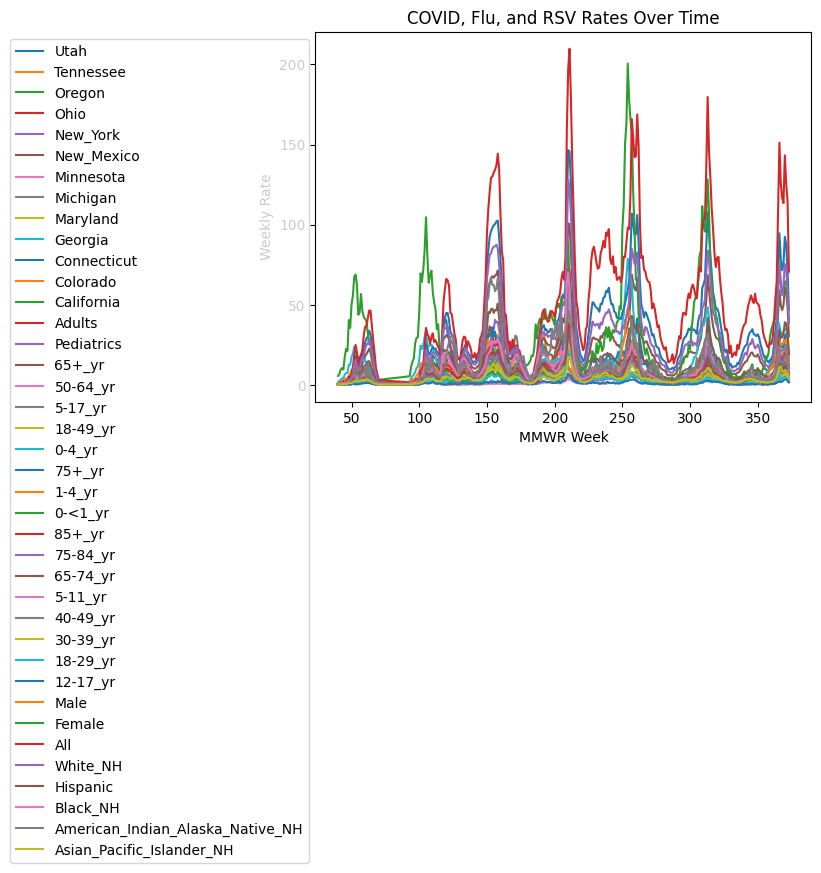

In [72]:
#pivot wider on the mmwr_year and mmwr_week columns
covid_rates_df_wide = covid_rates_df.pivot(index=['mmwr_year', 'mmwr_week'], columns=["age_group", "sex", "race_ethnicity", "site"], values='weekly_rate').reset_index()
covid_rates_df_wide

#squeeze the columns
covid_rates_df_wide.columns = ['_'.join(map(str, col)).replace(' ', '_') for col in covid_rates_df_wide.columns.values]
# replace the 'Overall_Overall_Overall_Overall' with 'all'
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('Overall_Overall_Overall_Overall', 'All')
#remove "Overall" from the column names
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('Overall', '')
#remove the leading and trailing underscores
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.strip('_')
#replace any , or / with _
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace(',', '_')
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('/', '_')
#replace any double _ with _
covid_rates_df_wide.columns = covid_rates_df_wide.columns.str.replace('__', '_')
#remove any columns with nas
covid_rates_df_wide = covid_rates_df_wide.dropna(axis=1, how='any')
#save the data to a csv file
covid_rates_df_wide.to_csv(output_prefix_01 + 'disease_rates_wide.csv', index=False)

#replace the mmwr_year with a multiple of 52 (53 for year 2020), starting at 2018 = 0, all the way to 2025
covid_rates_df_wide['mmwr_year'] = covid_rates_df_wide['mmwr_year'].replace({2018: 0, 2019: 52, 2020: 104, 2021: 157, 2022: 209, 2023: 261, 2024: 313, 2025: 365})
#add the mmwr_week to the mmwr_year
covid_rates_df_wide['mmwr_week'] = covid_rates_df_wide['mmwr_year'] + covid_rates_df_wide['mmwr_week']
#remove the mmwr_year column
covid_rates_df_wide = covid_rates_df_wide.drop(columns=['mmwr_year'])
#plot the data over mmwr_week for All
# plt.plot(covid_rates_df_wide['mmwr_week'], covid_rates_df_wide['All'])
# plt.title('COVID, Flu, and RSV Rates Over Time')
# plt.xlabel('MMWR Week')
# plt.ylabel('Weekly Rate')
# plt.show()

#save the data to a csv file
covid_rates_df_wide.to_csv(output_prefix_01 + 'disease_rates_wide.csv', index=False)
#iterate throught the columns and plot each one on the same graph
for col in covid_rates_df_wide.columns:
    if col != 'mmwr_week':
        plt.plot(covid_rates_df_wide['mmwr_week'], covid_rates_df_wide[col], label=col)
plt.title('COVID, Flu, and RSV Rates Over Time')
plt.xlabel('MMWR Week')
plt.ylabel('Weekly Rate')
#move the legend outside of the plot
plt.legend(loc='upper right', bbox_to_anchor=(0, 1))
plt.show()


In [ ]:
covid_rates_df["type"].value_counts()

## Data Processing

In [371]:
#transform adult dataframe
#pivotting the dataframe so that each row for a given year and location, and each column is the average value for different demographics for that metric
adult_df_very_wide = adult_df.pivot_table(index=['yearstart','locationabbr','geolocation'],columns=['class',"stratificationid1"],values="data_value")
#change the index to columns
adult_df_very_wide.reset_index(inplace=True)
#smoosh the column index
adult_df_very_wide.columns = ['_'.join(col).strip() for col in adult_df_very_wide.columns.values]
#replace whitespace with underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.replace(' ', '')
#remove trailing underscores
adult_df_very_wide.columns = adult_df_very_wide.columns.str.rstrip('_')
#add a prefix 'Adult' to all columns except for the first three
adult_df_very_wide.columns = ['adult_' + col if col not in ['yearstart','locationabbr','geolocation'] else col for col in adult_df_very_wide.columns]
#split the data in the geolocation column into two columns, 'latitude' and 'longitude', I tried doing this by transforming the dictionaries in this column but couldn't figure it out
#the geolocation column is a string that starts like this: "{'latitude': '37.7749', 'longitude': '-122.4194'}"
adult_df_very_wide["latitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[0].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
adult_df_very_wide["longitude"] = adult_df_very_wide['geolocation'].str.split(',', expand=True)[1].str.split(':', expand=True)[1].str.replace('\'','').astype(float).round(8)
#drop the geolocation column
adult_df_very_wide.drop(columns=['geolocation'], inplace=True)

#move the latitude and longitude columns to the front
cols = adult_df_very_wide.columns.tolist()
cols = cols[-2:] + cols[:-2]
adult_df_very_wide = adult_df_very_wide[cols]

adult_df_very_wide.columns = adult_df_very_wide.columns.str.replace('/', '')



In [372]:
print(adult_df_very_wide.shape)
#remove rows with nas in adult_ObesityWeightStatus_OVERALL
adult_df_very_wide.dropna(subset=['adult_ObesityWeightStatus_OVERALL'], inplace=True)
print(adult_df_very_wide.shape)
#remove columns with all na
adult_df_very_wide.dropna(axis=1, how='all', inplace=True)
print(adult_df_very_wide.shape)
#remove columns that are derived from the adult_ObesityWeightStatus_OVERALL column
adult_obesity_cols = [col for col in adult_df_very_wide.columns if col.startswith('adult_ObesityWeightStatus') and col != 'adult_ObesityWeightStatus_OVERALL']
adult_df_very_wide.drop(columns=adult_obesity_cols, inplace=True)
print(adult_df_very_wide.shape)
#remove locations with less than 7 data points (7 time points from 2011-2023)
location_counts = adult_df_very_wide['locationabbr'].value_counts()
locations_to_remove = location_counts[location_counts < 7].index.tolist()
adult_df_very_wide = adult_df_very_wide[~adult_df_very_wide['locationabbr'].isin(locations_to_remove)]
print(adult_df_very_wide.shape)



(684, 88)
(684, 88)
(684, 88)
(684, 61)
(680, 61)


In [373]:
print(adult_df_very_wide.isna().sum().sum())
#calculate column means grouped by location
group_means = adult_df_very_wide.groupby('locationabbr').mean()
#fill missing values with the mean of the column, matching locationabbr
for location in group_means.index:
    for col in group_means.columns:
        #check if the location is in the dataframe
        if location in adult_df_very_wide['locationabbr'].values:
            #check if the column is in the dataframe
            if col in adult_df_very_wide.columns:
                #fill missing values with the mean of the column
                adult_df_very_wide.loc[adult_df_very_wide['locationabbr'] == location, col] = adult_df_very_wide.loc[adult_df_very_wide['locationabbr'] == location, col].fillna(group_means.loc[location, col])
print(adult_df_very_wide.isna().sum().sum())
#impute the final missing values with the mean of the column except for the first 4 columns
adult_df_very_wide.iloc[:, 4:] = adult_df_very_wide.iloc[:, 4:].fillna(adult_df_very_wide.iloc[:, 4:].mean())
print(adult_df_very_wide.isna().sum().sum())


16815
2464
0


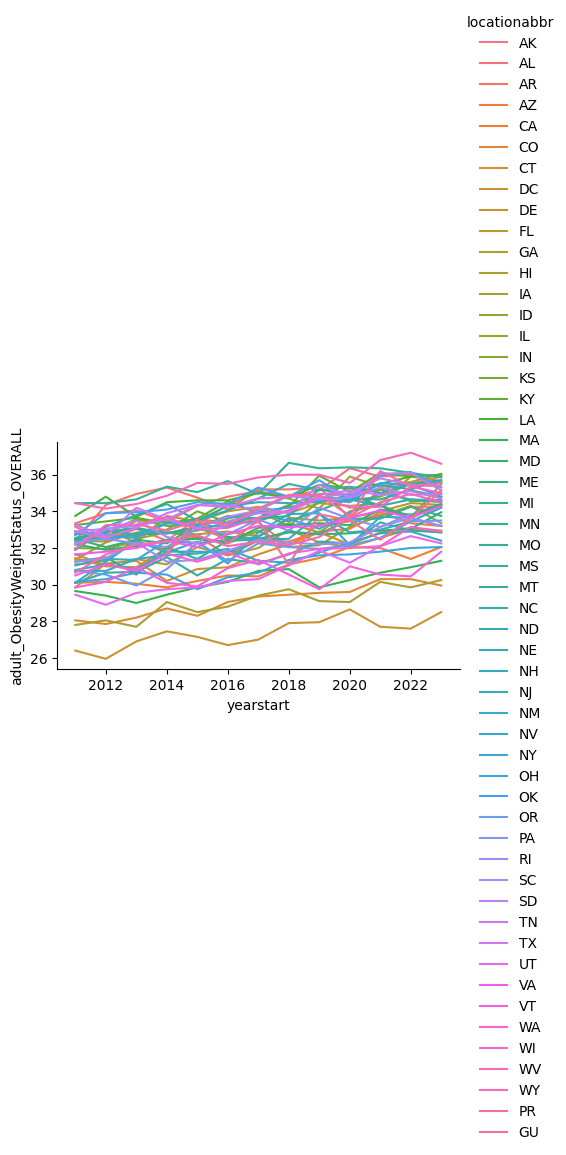

In [374]:
#plot a scatterplot of the adult obesity data over year colored by state
fg = sns.FacetGrid(data=adult_df_very_wide, hue='locationabbr', aspect=1.61)
fg.map(plt.plot, 'yearstart', 'adult_ObesityWeightStatus_OVERALL').add_legend()

In [375]:
#if output folder doesn't exist, make it
if not os.path.exists(output_prefix_01):
    os.makedirs(output_prefix_01)
#outputting the data to a csv file
adult_df_very_wide.to_csv(output_prefix_01+'data.csv', index=False)